# Sementic segmentation of flair1 data with a basic UNet

In [ ]:
#!git clone https://github.com/BertilleT/LandCover_map_Transformers_SSL.git
!pip install rasterio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import all the necessary modules
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path
from utils import *
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from pathlib import Path
import random
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from metrics import PixelwiseMetrics
import matplotlib.pyplot as plt
import seaborn as sns

## Prepare the data
1) Download the data and split it into training, validation and test sets.
2) Analyse the balance of classes in the dataset.
3) Create a Dataloader
4) Load the data

In [ ]:
class Flair1Dataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, seed = 42):
        super(Flair1Dataset, self).__init__()
        self.resize_transform = transforms.Resize((256, 256))
        self.resize_transform_l = transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)
        self.folder_path = folder_path
        self.img_files = sorted(list(get_data_paths(Path(self.folder_path), 'image*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
        self.mask_files = sorted(list(get_data_paths(Path(self.folder_path), 'mask*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
        self.total = len(self.img_files)
        self.n_classes = 13
        self.n_inputs = 3

    def __len__(self):
        return self.total

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]

        data = rasterio.open(img_path).read()
        data = data[0:3, :, :]
        label = rasterio.open(mask_path).read()
        label = label - 1
        # Convert data to PIL Image for resizing
        data = np.transpose(data, (1, 2, 0))
        data = transforms.ToPILImage()(data)
        data = self.resize_transform(data)
        # Convert back to tensor
        data = transforms.ToTensor()(data)

        # Convert label to PIL Image for resizing
        label = np.transpose(label, (1, 2, 0))
        label = transforms.ToPILImage()(label)
        label = self.resize_transform_l(label)
        #print values uniques in label
        # Convert back to tensor
        label = torch.from_numpy(np.array(label, dtype=np.uint8))
        label = label.long()

        #Turn data and label into float between 0 and 1
        # data = data / 255
        # label = label / 255
        return data, label

    def get_per_per_class(self):
        class_per = dict.fromkeys(range(1,20), 0)
        total_pixels = 0
        for i in range(len(self)):
            _, label = self[i]
            for j in range(1,20):
                class_per[j] += torch.sum(label == j).item()
            total_pixels += label.numel()
        for j in range(1,20):
            class_per[j] = class_per[j] / total_pixels
        return class_per


In [ ]:
my_set = 'fullset' # or 'subset'
data_config = {
    'train_path': 'drive/MyDrive/MVA/flair1_' + my_set + '_13classes/train', 
    'val_path': 'drive/MyDrive/MVA/flair1_' + my_set + '_13classes/val', 
    'test_path': 'drive/MyDrive/MVA/flair1_' + my_set + '_13classes/test', 
    'n_classes': 13, # number of classes in the dataset.
    'n_inputs': 5, # number of channels in input data
    'seed': 42,
    'batch_size': 32,
}

In [ ]:
train_ds = Flair1Dataset(data_config['train_path'])
val_ds = Flair1Dataset(data_config['val_path'])
test_ds = Flair1Dataset(data_config['test_path'])

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=data_config['batch_size'], shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=data_config['batch_size'], shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=data_config['batch_size'], shuffle=True)

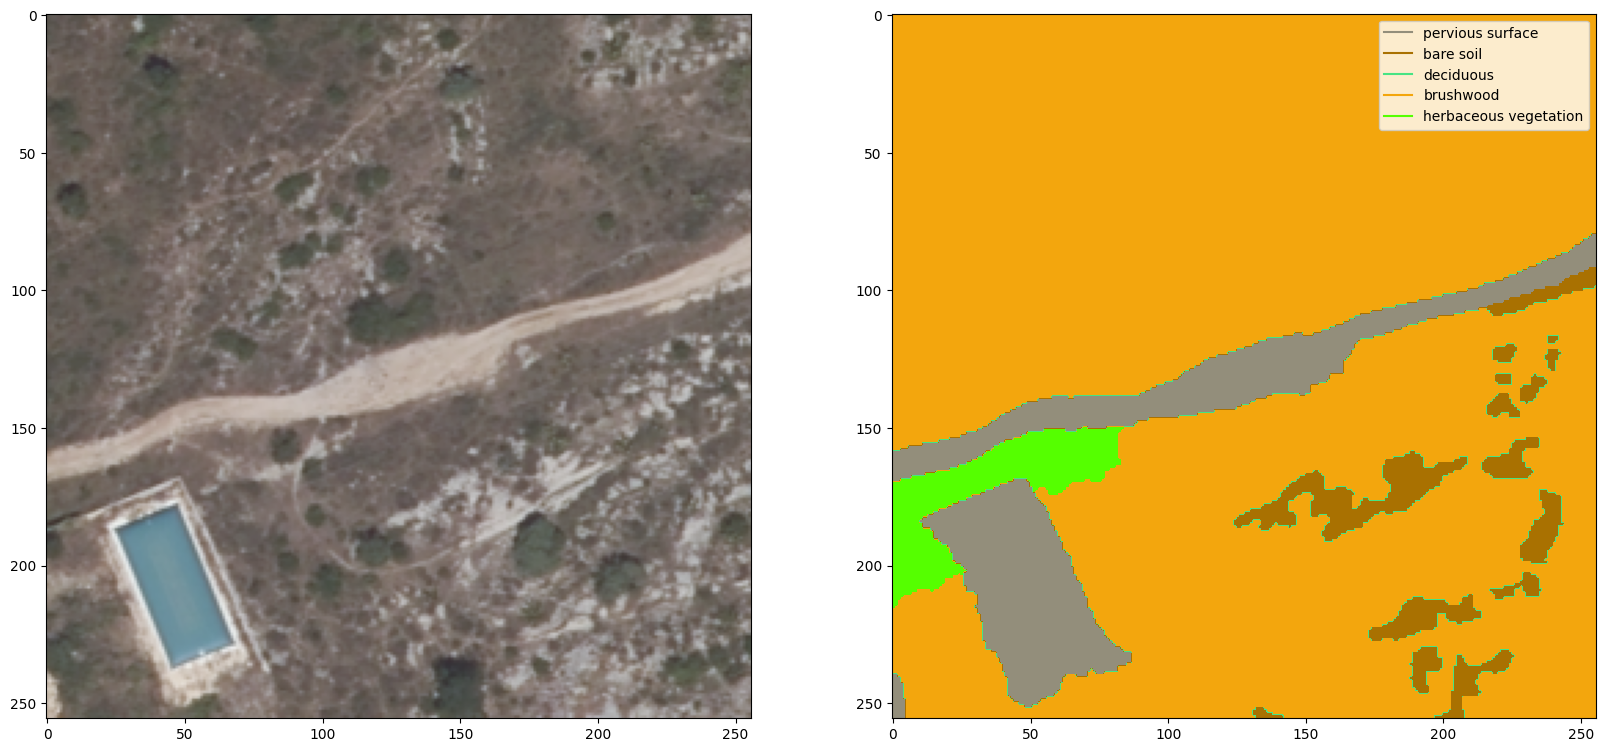

In [ ]:
img, msk = next(iter(train_dl))
plot_image_mask_2(img[0], msk[0], colors_13, dict_classes_13)

## Create the model

In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [ ]:
# Training configurations
train_config = {
    'learning_rate': 0.01,
    'batch_size': 16,
    'epochs': 20,
    'seed': 42,
    'weight_decay': 5e-4, 
    'model_path': '../../drive/MyDrive/MVA/UNet_20.pth',
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = UNet(n_classes=data_config['n_classes'], n_channels=data_config['n_inputs']) #pixel value from 1 to 13 and 5 channels
model = model.to(train_config['device'])

criterion = nn.CrossEntropyLoss(ignore_index=255, reduction='mean')
optimizer = torch.optim.RMSprop(
    model.parameters(), 
    lr=train_config['learning_rate'], 
    weight_decay=train_config['weight_decay']
)


## Train and validate

In [ ]:
step = 0

#Training loop
train_losses = []
val_losses = []

for epoch in range(train_config['epochs']):
    # Model Training
    model.train()
    step += 1

    pbar = tqdm(train_dl)

    # track performance
    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['num_classes'])

    for idx, (img, y) in enumerate(pbar):
        # load target
        y = y.to(device)
        # model output
        y_hat = model(img)

        # loss computation
        loss = criterion(y_hat, y)

        # backward step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # get prediction
        _, pred = torch.max(y_hat, dim=1)

        epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
        metrics.add_batch(y, pred)

        pbar.set_description(f"Epoch:{epoch}, Training Loss:{epoch_losses[-100:].mean():.4}")

    mean_loss = epoch_losses.mean()
    train_losses.append(mean_loss)
    train_stats = {
            "train_loss": mean_loss.item(),
            "train_average_accuracy": metrics.get_average_accuracy(),
            "train_mIoU": metrics.get_mIoU(),
            **{
                "train_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
                "train_IoU_" + k: v
                for k, v in metrics.get_IoU().items()
            },
        }
    print(train_stats)

    # Model Validation
    model.eval()
    pbar = tqdm(val_dl)

    # track performance
    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['num_classes'])

    with torch.no_grad():
        for idx, (img, y) in enumerate(pbar):
            y = y.to(device)
            # model output
            y_hat = model(img)

            # loss computation
            loss = criterion(y_hat, y)

            # get prediction
            _, pred = torch.max(y_hat, dim=1)

            epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
            metrics.add_batch(y, pred)


            pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

        mean_loss = epoch_losses.mean()
        val_losses.append(mean_loss)
        val_stats = {
            "validation_loss": mean_loss.item(),
            "validation_average_accuracy": metrics.get_average_accuracy(),
            "validation_mIoU": metrics.get_mIoU(),
            **{
                "validation_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
            "train_IoU_" + k: v
            for k, v in metrics.get_IoU().items()
        },
        }

        print(f"Epoch:{epoch}", val_stats)

        # Save model checkpoint every 2 epochs
        if epoch % 2 == 0:
            if epoch == 0:
                continue

            save_weights_path = (
                "checkpoints_Unet/" + "-".join(["segmentation", "epoch", str(epoch)]) + ".pth"
            )
            torch.save(model.state_dict(), save_weights_path)

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
torch.save(model.state_dict(), train_config['model_path'])

## Test

In [ ]:
def test(model, test_ld):
    model.eval()
    pbar = tqdm(test_ld)

    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['num_classes'])
    all_preds = []
    all_gts = []
    with torch.no_grad():
        for idx, (img, y) in enumerate(pbar):
            y = y.to(device)
            # model output
            y_hat = model(img)

            # loss computation
            loss = criterion(y_hat, y)

            # get prediction
            _, pred = torch.max(y_hat, dim=1)
            all_gts.append(y.cpu().numpy())
            all_preds.append(pred.cpu().numpy())
            epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
            metrics.add_batch(y, pred)


            pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

        mean_loss = epoch_losses.mean()
        test_stats = {
            "test_loss": mean_loss.item(),
            "test_average_accuracy": metrics.get_average_accuracy(),
            "test_mIoU": metrics.get_mIoU(),
            **{
                "test_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
                "train_IoU_" + k: v
                for k, v in metrics.get_IoU().items()
            },
        }
        print("Test stats:")

        # Loss
        print(f"  Loss: {test_stats['test_loss']:.4f}")

        # Average accuracy and mIoU
        print(f"  Average Accuracy: {test_stats['test_average_accuracy']:.4f}")
        print(f"  Mean IoU: {test_stats['test_mIoU']:.4f}")

        # Accuracy per class
        print("  Accuracy by Class:")
        for i in range(data_config['num_classes']):
            print(f"    Class {i}: {test_stats[f'test_accuracy_pixelclass_{i}']:.4f}")

        # IoU per class
        print("  IoU by Class:")
        for i in range(data_config['num_classes']):
            print(f"    Class {i}: {test_stats[f'train_IoU_class_{i}']:.4f}")
        all_preds = np.concatenate(all_preds)
        all_gts = np.concatenate(all_gts)

        # Calculer la matrice de confusion
        conf_matrix = confusion_matrix(all_gts.flatten(), all_preds.flatten(), labels=np.arange(data_config['num_classes']))
        # Normalisation par lignes
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        sns.set(font_scale=0.8)

        # Tracer la matrice de confusion
        plt.figure(figsize=(10, 10))
        ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=list(dict_classes_13.values()), yticklabels=list(dict_classes_13.values()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        #sns.set(font_scale=1.2)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
    return

In [ ]:
# create a new model's instance
model = UNet(n_classes=data_config['n_classes'], n_channels=data_config['n_inputs'])
model = model.to(device)

# load checkpoints weights
model.load_state_dict(torch.load(train_config['model_path']))

test(model, test_dl)

1
2
3
7
8
9
10
11


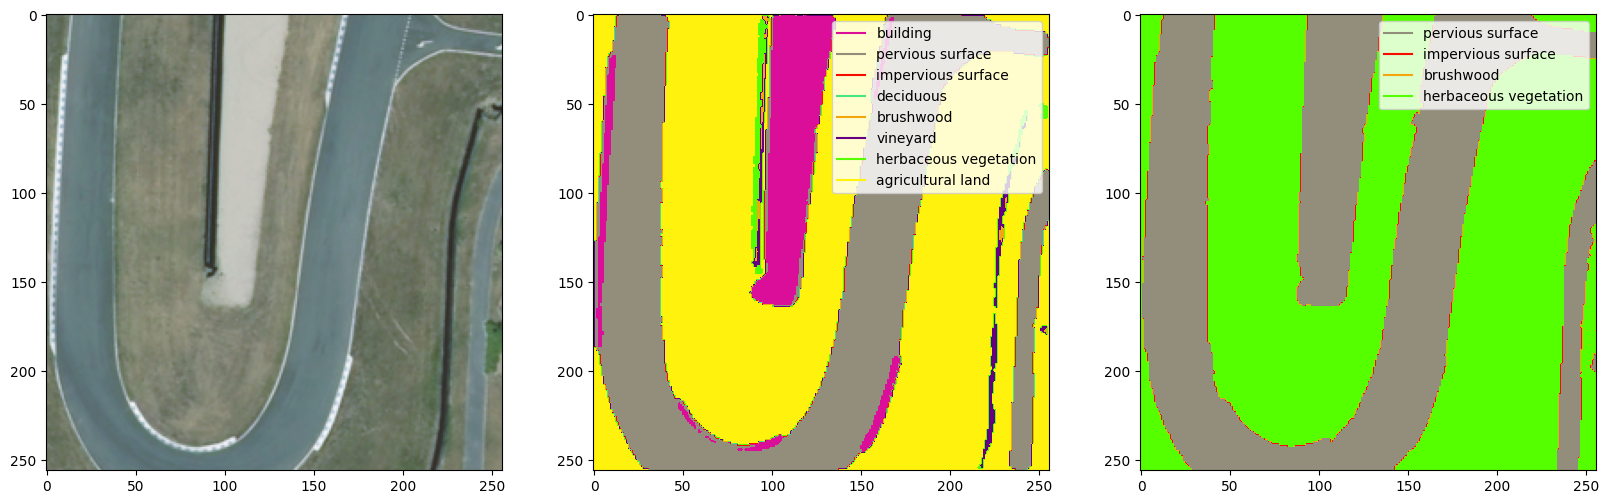

In [ ]:
img, target = next(iter(val_dl))
pred = model(img.cuda()).cpu().detach()
plot_pred(img[0], pred[0], target[0], dict_classes_13, colors_13)